## Simple Control Problem with Neural ODE

In [1]:
%reset -f

In [2]:
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax

import time
from utils import *;

<Figure size 640x480 with 0 Axes>

For some reason, GPU is really slow on this task, so let's use CPU

In [3]:
jax.config.update('jax_platform_name', 'cpu')
print(jax.numpy.ones(3).device()) # should be TFRT_CPU_0

TFRT_CPU_0


We are solving the optimal control problem:
\begin{align}
    u^*(t) = \argmin_{u(t)}{J(u)}
\end{align}
- with $J(u) = \frac{1}{2}\left( y(T) - y^* \right)^2$ (the energy cost is not yet considered)
- subject to the ODE $y'(t) = u(t)$, 
- terminal states $y(0) = y_0$, and $y(T) \approx y^*$

We want to lean a near-optimal control $\hat u$ by parametrising it via a MLP; or even better, an even simpler linear layer.

In [4]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    # weight: jax.numpy.ndarray
    # bias: jax.numpy.ndarray

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size+1,        ## Input is t and y0
            out_size=data_size,         ## Output is yT
            width_size=width_size,
            depth=depth,
            # activation=jax.nn.softplus,
            activation=lambda x:x,      ## No activation at all
            key=key,
        )

        ## Initialise these weights close to OC
        # self.weight = jnp.array([[0., -1.]]) + jax.random.normal(key, (2,))
        # self.bias = jnp.array([1.]) + jax.random.normal(key, (1,))

    def __call__(self, t, y, *args):
        input_vec = jnp.array([t, args[0][0]])  ## args[0] is the y0 PyTree (of size 1) - input_vec must be a 1D array to avoid broadcasting
        return self.mlp(input_vec)
        # return self.weight @ input_vec + self.bias
        # return self.weight @ input_vec

In [5]:
T = 1.0
N = 200

data_size = 1
width_size = 1
depth = 0
seed = int(time.time())
# seed = 3440
key = jax.random.PRNGKey(seed)

test_control = Func(data_size, width_size, depth, key=key)
print("Behold the control term: \n----------------------- \n", test_control)
# print(test_control.weight)
# print(test_control.bias)

ts = jnp.linspace(0, T, N)
y0 = jnp.array([1.0])

print("\nTesting the control term: \n----------------------- \n", test_control(ts[0], y0, y0))

Behold the control term: 
----------------------- 
 Func(
  mlp=MLP(
    layers=[
      Linear(
        weight=f32[1,2],
        bias=f32[1],
        in_features=2,
        out_features=1,
        use_bias=True
      )
    ],
    activation=<function <lambda>>,
    final_activation=<function _identity>,
    in_size=2,
    out_size=1,
    width_size=1,
    depth=0
  )
)

Testing the control term: 
----------------------- 
 [0.31756774]


We now deffine the control problem using the Neural ODE formulation.

In [6]:
class NeuralODE(eqx.Module):
    u: Func

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.u = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.u),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1]-ts[0],
            y0=y0,
            args=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [7]:
model = NeuralODE(data_size, width_size, depth, key=key)
model(ts, y0)

DeviceArray([[1.       ],
             [1.0016005],
             [1.0032105],
             [1.0048299],
             [1.0064588],
             [1.0080972],
             [1.0097449],
             [1.0114021],
             [1.0130688],
             [1.014745 ],
             [1.0164305],
             [1.0181255],
             [1.01983  ],
             [1.0215439],
             [1.0232673],
             [1.0250001],
             [1.0267423],
             [1.028494 ],
             [1.0302552],
             [1.0320258],
             [1.0338058],
             [1.0355953],
             [1.0373943],
             [1.0392027],
             [1.0410205],
             [1.0428478],
             [1.0446845],
             [1.0465307],
             [1.0483863],
             [1.0502514],
             [1.0521259],
             [1.0540098],
             [1.0559033],
             [1.0578061],
             [1.0597185],
             [1.0616401],
             [1.0635713],
             [1.0655121],
            

Given the target state $y^*$, we can randomly construct training data.

In [8]:
ystar = 1.0 ## target state

def _get_data(ts, *args, key):
    y0 = jax.random.uniform(key, (1,), minval=-2.0, maxval=4.0)
    yT = jnp.array([ystar])
    return jnp.stack([y0, yT], axis=0)     ## data_size is 1

def get_data(dataset_size, *args, key):
    ts = jnp.linspace(0, T, N)
    key = jax.random.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [9]:
def dataloader(array, batch_size, *args, key):
    dataset_size = array.shape[0]
    indices = jnp.arange(dataset_size)
    perm = jax.random.permutation(key, indices)
    start = 0
    end = batch_size
    while end < dataset_size:
        batch_perm = perm[start:end]
        yield array[batch_perm]
        start = end
        end = start + batch_size

In [10]:
dataset_size = 256
batch_size = 32
data_key, loader_key = jax.random.split(key, 2)

_, ys = get_data(dataset_size, key=data_key)
train_loader = dataloader(ys, batch_size, key=loader_key)

## Test the dataloader
for i, batch in enumerate(train_loader):
    if i < 1: print(batch)

[[[-1.517703  ]
  [ 1.        ]]

 [[ 3.4538887 ]
  [ 1.        ]]

 [[ 2.8290784 ]
  [ 1.        ]]

 [[ 0.9236171 ]
  [ 1.        ]]

 [[-0.38279963]
  [ 1.        ]]

 [[ 1.609659  ]
  [ 1.        ]]

 [[-0.99940157]
  [ 1.        ]]

 [[ 3.9643095 ]
  [ 1.        ]]

 [[ 0.8914428 ]
  [ 1.        ]]

 [[ 1.6496961 ]
  [ 1.        ]]

 [[ 2.6191301 ]
  [ 1.        ]]

 [[ 1.62783   ]
  [ 1.        ]]

 [[ 2.0438213 ]
  [ 1.        ]]

 [[ 1.7779708 ]
  [ 1.        ]]

 [[-1.8985875 ]
  [ 1.        ]]

 [[ 1.0560746 ]
  [ 1.        ]]

 [[ 2.6930017 ]
  [ 1.        ]]

 [[-0.99296284]
  [ 1.        ]]

 [[-1.3068635 ]
  [ 1.        ]]

 [[ 1.960326  ]
  [ 1.        ]]

 [[-1.2860596 ]
  [ 1.        ]]

 [[ 2.750087  ]
  [ 1.        ]]

 [[ 1.1764915 ]
  [ 1.        ]]

 [[ 2.253872  ]
  [ 1.        ]]

 [[ 0.43095183]
  [ 1.        ]]

 [[-0.20784163]
  [ 1.        ]]

 [[-0.9548218 ]
  [ 1.        ]]

 [[ 1.429599  ]
  [ 1.        ]]

 [[ 3.8905287 ]
  [ 1.        ]]

 [[ 0.4389441 

In [11]:
lr = 3e-3
optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    return jnp.mean(0.5 * (yi[:, -1] - y_pred[:, -1]) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

Step: 100, Loss: 0.346547394990921, Computation time: 0.0049610137939453125
Step: 200, Loss: 0.039205387234687805, Computation time: 0.005731105804443359
Step: 300, Loss: 0.0009650092106312513, Computation time: 0.006148576736450195
Step: 400, Loss: 8.609761607658584e-06, Computation time: 0.0060024261474609375
Step: 500, Loss: 3.291030026275621e-08, Computation time: 0.0043485164642333984
Step: 600, Loss: 2.627392747811541e-11, Computation time: 0.005404233932495117
Step: 700, Loss: 4.743982984223294e-13, Computation time: 0.00667572021484375


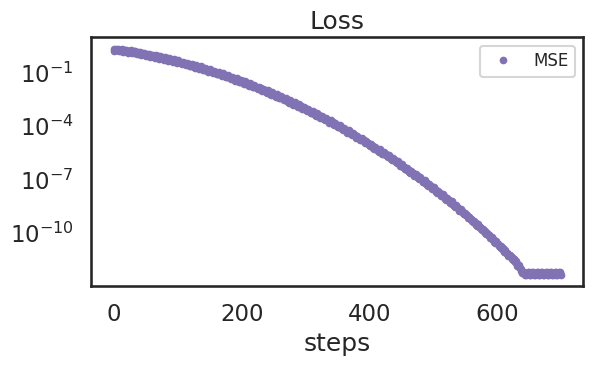

In [12]:
epochs = 100

step = 0
losses = []
for epoch in range(epochs):
    for yi in dataloader(ys, batch_size, key=loader_key):
        start = time.time()
        loss, model, opt_state = make_step(ts, yi, model, opt_state)
        end = time.time()
        step += 1
        losses.append(loss)
        if (step % 100) == 0:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

fig, ax = plt.subplots(1,1,figsize=(6,4))
plot(losses, "m.", label="MSE", x_label="steps", title="Loss", ax=ax)
ax.set_yscale('log')

Let's plot the results, and compare them to the known constant optimal control:
\begin{align}
u^*(t) = \frac{y^* - y_0}{T}
\end{align}
**N.B.** This is the desired optimal control because it also minimises the energy functional $E(u) = \int_0^T \Vert u \Vert^2 \, \text{d}t$. Otherwise, many different controls solve this problem elegantly.

In [13]:
## Printing the weights
if hasattr(model.u, 'mlp'):
    print("Learned control weights:", model.u.mlp.layers[0].weight)         ## Should idealy be [0, -1]/T
    print("Learned control bias:", model.u.mlp.layers[0].bias)              ## Should idealy be ystar/T = 1
    print("Check NN strategy:", model.u.mlp.layers[0].weight[0][0] + 2*model.u.mlp.layers[0].bias[0] - 2)
else:
    print("Learned control weights:", model.u.weight) 
    print("Learned control bias:", model.u.bias) 
    print("Check NN strategy:", model.u.weight[0][0] + 2*model.u.bias[0] - 2)

Learned control weights: [[ 0.7795202 -0.9999994]]
Learned control bias: [0.61023885]
Check NN strategy: -2.1457672e-06


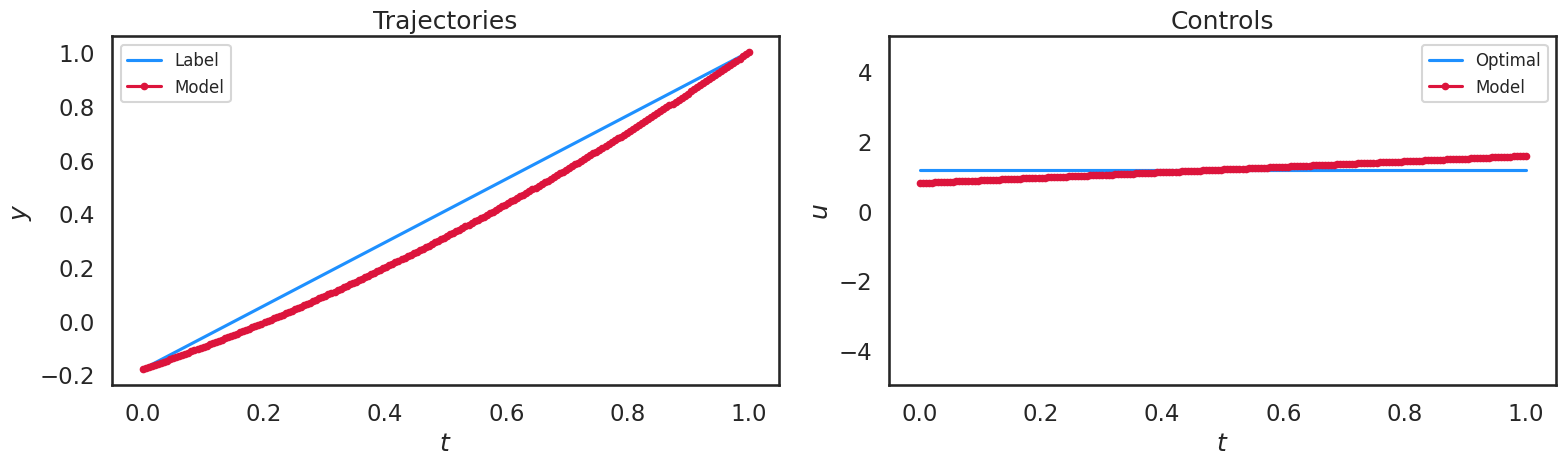

In [14]:
test_gen_key = jax.random.PRNGKey(int(time.time()))

ytrue = _get_data(ts, key=test_gen_key)
ypred = model(ts, ytrue[0])[:]
utrue = jnp.ones_like(ytrue) * (ystar-ytrue[0])/T
upred = jax.vmap(model.u, in_axes=(0, None, None))(ts, ypred, ypred[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8*2, 5))
tplot = [ts[0], ts[-1]]
ax1 = plot(tplot, ytrue, c="dodgerblue", label="Label", title="Trajectories", x_label=r"$t$", y_label=r"$y$", ax=ax1)
ax1 = plot(ts, ypred, ".-", c="crimson", label="Model", ax=ax1)

ax2 = plot(tplot, utrue, c="dodgerblue", label="Optimal", title="Controls", x_label=r"$t$", y_label=r"$u$", ax=ax2)
ax2 = plot(ts, upred, ".-", c="crimson", label="Model", ax=ax2)
ax2.set_ylim(-5, 5);

## Findings
The follwing features were implemented in Neural ODE and interpreted:
- Included control $u$ as a function of $y$: could neither recover trajectories nor controls
- Included control $u$ as a function only of $t$: could not recover trajectories but not too bad on controls
- Included control $u$ as function of both $t$ and $y_0$: could almost perfectly recover trajectories, but completely wrong on optimal controls

In the abscence of the energy functional, the neural network tells us that optimal control that is in the form 
\begin{align}
&u(t) = at + by_0 + c \\
&\text{with  } \frac{1}{2}aT^2 + bTy_0 + cT + y_0 = y^*
\end{align} 
With $T=1$ and $y^*=1$, the neural network seems to understand that the best choice is $b=-1$, and set $a + 2c - 2 = 0$. This is why our modelled control is only **near-optimal**.

So, the MIN (Minimally Interpretably Network) for this problem is simply 2 input neurons without bias and 1 output neuron. In total, just 2 learnable parameters (HINT: setting $c=0$ leads to $a = 2$). (We showed this using a linear layer: the `bias` is not needed). 

Quite different from what they did in https://iopscience.iop.org/article/10.1088/2632-2153/ac92c3/pdf, since initialisation is not a big problem in our case.

## Next steps
- Reproduce this experiment with the energy functional
- Include middle position as extra constraint
- Use SINDy to recover the governing equation for the controls
- Uncertainty quantify the trajectories, especially when initial state is known
- Generate trajectories based on probability density estimation